<h1> Predicting User Knowledge Level Using KNN Classification</h1>
<h2> DSCI 100: Group 38 Final Project </h2>

<b>Introduction: </b>

- <u>Background: </u> The dataset we are using is the “User Knowledge Modelling Dataset” from the UCI Machine Learning Repository. It was created and designed for a study in creating efficient user knowledge classfiers. Consisting information of 403 undergraduate students in the Department of Electrical Education of Gazi University in the 2009 semester, the dataset aims to classify students’ level of knowledge on the subject of Electrical DC Machines. 

- <u>Dataset description: </u>
    - Dataset title:  <b> <a href="https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling"> User Knowledge Modeling Data Set </a> </b>
    - The dataset consists of 403 rows and 6 columns - 5 quantitative varaibles and 1 qualitative variable. It is split into training and testing sets, with 258 observations in training and 145 in testing. 
    - Dataset terminology:
    
        <b>STG</b> - The degree of study time for goal object materials (Quantitative)

        <b>SCG</b> - The degree of repetition number of user for goal object materials (Quantitative)

        <b>STR</b> - The degree of study time of user for related objects with goal object (Quantitative)

        <b>LPR</b> - The exam performance of user for related objects with goal object (Quantitative)

        <b>PEG</b> - The exam performance of user for goal objects (Quantitative)

        <b>UNS</b> - The knowledge level of user (Qualitative)
    
- <u>Objectives</u>: From the raw dataset, the target value is UNS and is classified through input values: STG, SCG, STR, LPR, and PEG. Our objective is to determine the category of UNS assigned to the user based on PEG (we will discuss later why we only choose this variable as the predictor) with k-NN classification. The target value is the knowledge level of students/ ‘users’ about the subject of Electrical DC Machines in which its features is PEG and its categories are:
    - Very low
    - Low
    - Middle
    - High
    
    <br>

<b> Methods & Results: </b>

- <u>Preliminary exploratory data analysis: </u>

Firstly, we loaded in the packages that were needed, and set the seed so that everything is reproducible for the data analysis. </i>

In [42]:
library(tidyverse)
library(readxl)
library(digest)
library(dplyr)
library(repr)
library(tidymodels)
library(GGally)
library(themis)
options(repr.matrix.max.rows = 6)

set.seed(9999) #Randomly splits the data through randomness by producing a sequence of numbers that are determined by a seed value. 
               #Used to ensure that the results are reproducible by ensuring that the data is 
               #divided the same way every time the code is run and increases reproducibility.

<br>

We loaded the data into R by downloading the file, where we then read the training dataset. Then, we selected all the variable columns from the data and mutated UNS as a factor. <b>There was no need to wrangle the data into tidy format since it was already provided as such. </b> Each row is a single observation, each column is a single variable and each value is a single cell.
    
Now we need to choose the suitable predictor(s) for our prediction. We used the ggpairs function to find the correlations between all the variables and UNS, so that we can choose the ones with relatively strong correlations with UNS as predictor(s). But we noticed that UNS was not in numeric form, so we assigned each UNS category a numeric value, from 1 to 4, representing the lowest level to the highest level. 

Notice below we used c(1,4,2,3) instead of normal ordering because the first four rows of the UNS column in the training dataset are "very_low, high, low, middle". They are not from the lowest level to the highest level as we wanted. If we used its default ordering (1:4), then the "High" level would be assigned the number 2, the "low" level would be assigned the number 3, and the "middle" level would be assigned the number 2. Because of this, we need to assign the categories as 1, 4, 2, and 3.

In [43]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
              "user_modeling_data.xls")        #loads data from the original source on the web 

original_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (the training data)
                     select(STG : UNS)
head(original_training, 5)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


Table 1: Training data set (first 5 observations)
<br> </br>
<br> </br>

In [44]:
whole_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (the training data)
                     select(STG : UNS)%>%              #select columns from STG to UNS
                     mutate(UNS = c(1,4,2,3)[as_factor(UNS)])      #change the categorical data of the UNS column into numeric form in specific order
head(whole_training, 5)    # take a look at the first five rows of the edited dataset

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,1
0.08,0.08,0.10,0.24,0.90,4
0.06,0.06,0.05,0.25,0.33,2
0.10,0.10,0.15,0.65,0.30,3
0.08,0.08,0.08,0.98,0.24,2


Table 2: Training data set with UNS categories changed into numeric form (first 5 observations)


<br> </br>

Now we can see from Table 2 that all four categories in the UNS column are assigned a number corresponding to the data point's knowledge level. Because of that, now we are able to use the ggpairs function to visualize the correlations between all of the other variables with UNS.

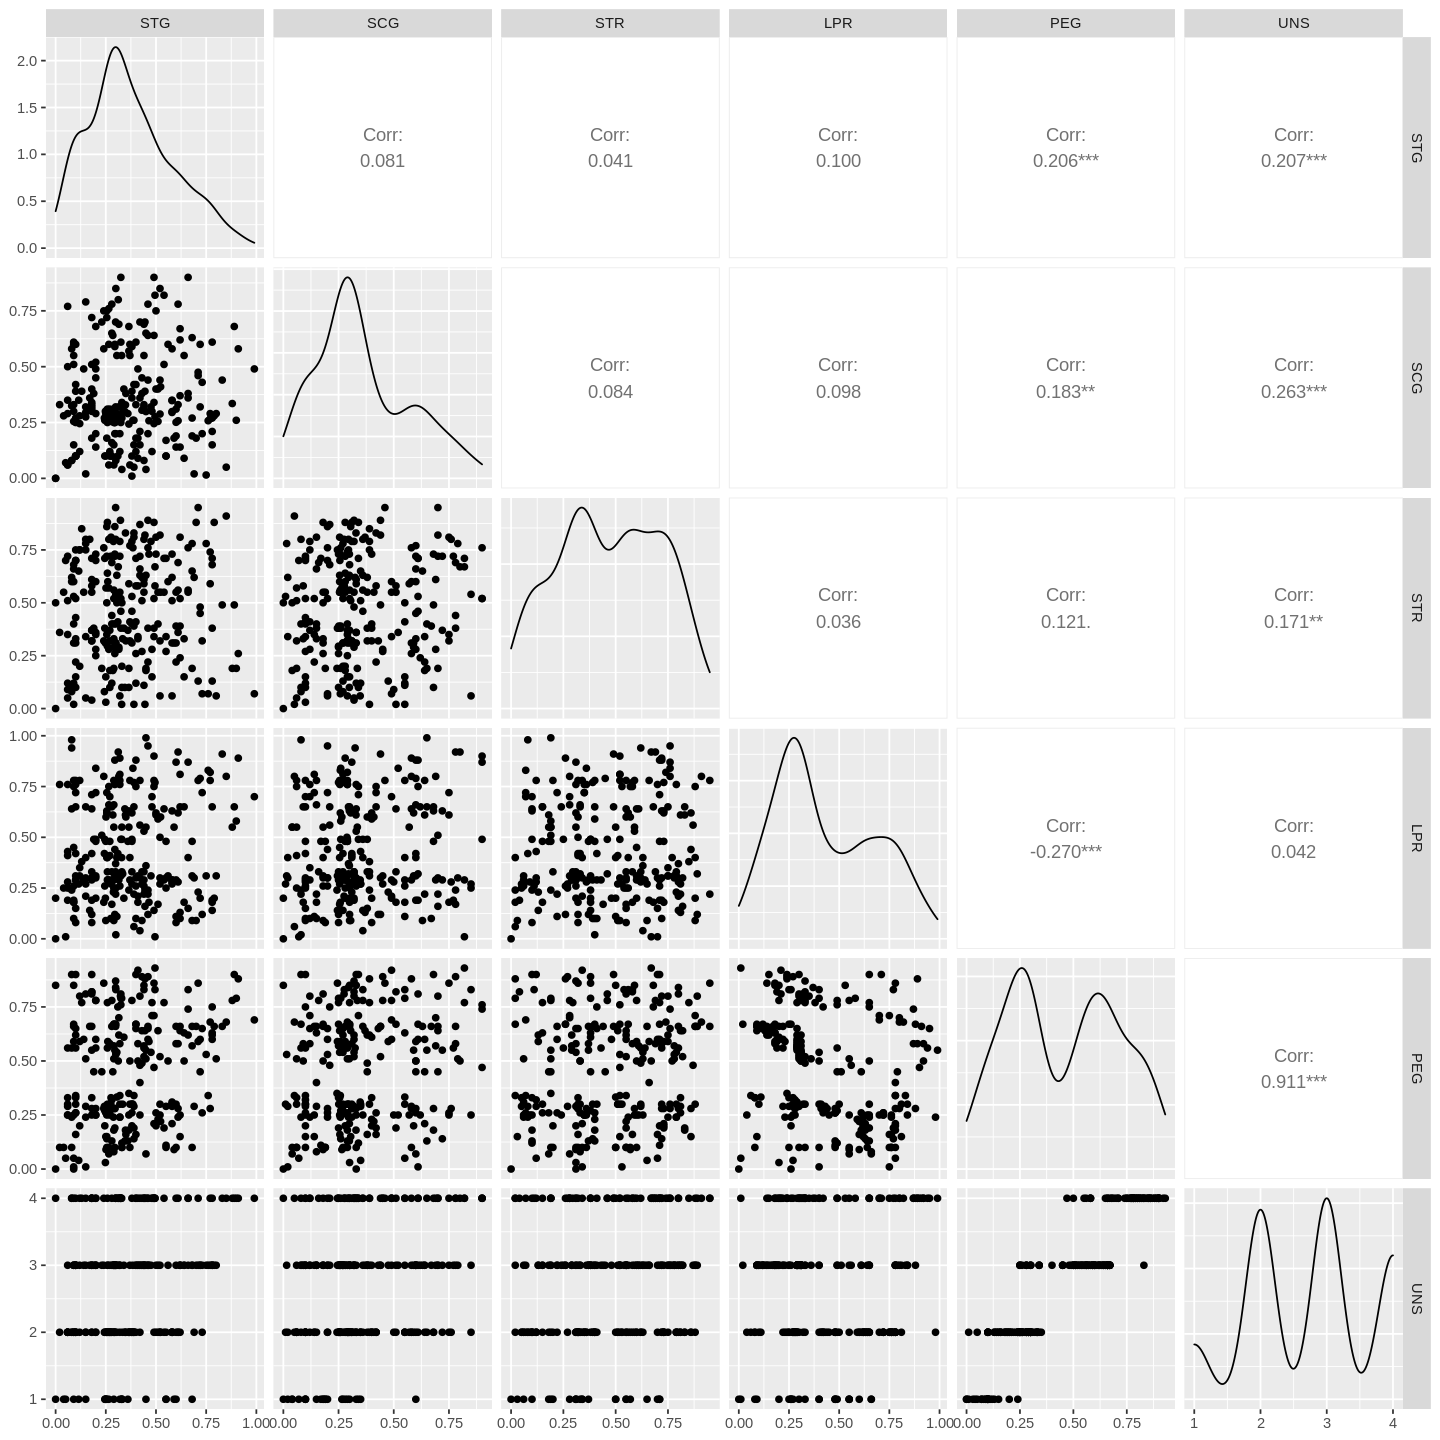

In [45]:
ggpairs(whole_training)

Figure 1: Correlation between Variables in the Data Set



<br>
We can see from Figure 1 that only PEG has a relatively strong correlation with UNS, at a value of 0.911. As all the other predictors have a very low correlation value, we decided to choose PEG as the only predictor.

<br>

Now we can just select the PEG and UNS columns for both the training data and testing data from the original dataset. Since we have chosen the predictor, we no longer need to keep the UNS column in numeric form. Notice how we renamed one of the values of the UNS column in the testing data to make all the categories have the same name. (The testing data represents the lowest level as "Very Low", but the training data uses "very_low" to represent the lowest level.) If we don't do this, the accuracy of our prediction would be severely affected.

In [46]:
# create the training data
dataset_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (training data)
                     select(PEG,UNS)%>%              #select only predictor and target variable columns
                     mutate(UNS = as_factor(UNS))   # change the UNS column into factor form
head(dataset_training, 5)       # take a look at the first 5 rows of the training data

# create the testing data
dataset_testing <- read_excel('user_modeling_data.xls', sheet = 3)%>%     #only read the third sheet from the file (testing data)
                     select(PEG,UNS)%>%             #select only predictor and target variable columns
                     mutate(UNS = ifelse(UNS == "Very Low", "very_low", UNS))%>%   # make all the values in UNS column same
                     mutate(UNS = as_factor(UNS))         # change the UNS column into factor form

New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.00,very_low
0.90,High
0.33,Low
0.30,Middle
0.24,Low


New names:
* `` -> ...7
* `` -> ...8



Table 3: Training dataset with only the PEG and UNS columns selected (first 5 observations).
<br> </br>

<br>
Here we reordered the categories of the UNS column for the testing data to match the training data.

In [47]:
#makes the factor levels of the training and testing data the same, originally was different
dataset_training$UNS <- ordered(dataset_training$UNS, levels = c("very_low","Low", "Middle", "High")) 
dataset_testing$UNS <- ordered(dataset_testing$UNS, levels = c("very_low","Low", "Middle", "High")) 

<br>

By making a table, we can see the distribution of each UNS category in the training data in regards to their counts and percentages compared to the training dataset. </i>

In [48]:
num_UNS <- dataset_training %>%
           group_by(UNS) %>%        # group by the UNS column
           summarise(count = n(),             #calculate the number of observations for each status of UNS
                     percentage = n() / nrow(dataset_training) *100)    #calculates the percentage of each UNS category
num_UNS

UNS,count,percentage
<ord>,<int>,<dbl>
very_low,24,9.302326
Low,83,32.170543
Middle,88,34.108527
High,63,24.418605


Table 4: Distribution of each UNS category in the training data, including their counts and percentages compared to the training dataset.
<br> </br>

We concluded there is no missing data in the training data. </b>

In [49]:
nrow(dataset_training%>%filter(is.na(UNS)))   # find the number of rows with missing data in UNS column
nrow(dataset_training%>%filter(is.na(PEG)))   # find the number of rows with missing data in PEG column

[1] 0

[1] 0

<br> </br>
Through R, we also calculated the average PEG score for the training data to be 0.46.

In [50]:
PEGavg <- dataset_training %>%
          summarize(PEGavg = mean(PEG))   #calculate the mean PEG score in the training set
PEGavg

PEGavg
<dbl>
0.4585388


Table 5: The average PEG score for the training data.

<br>

- <u>Visualization relevant for exploratory data analysis related to the planned analysis:</u>

Lastly, we drew a bar plot to visualize the distribution of the number of observations for each UNS category.

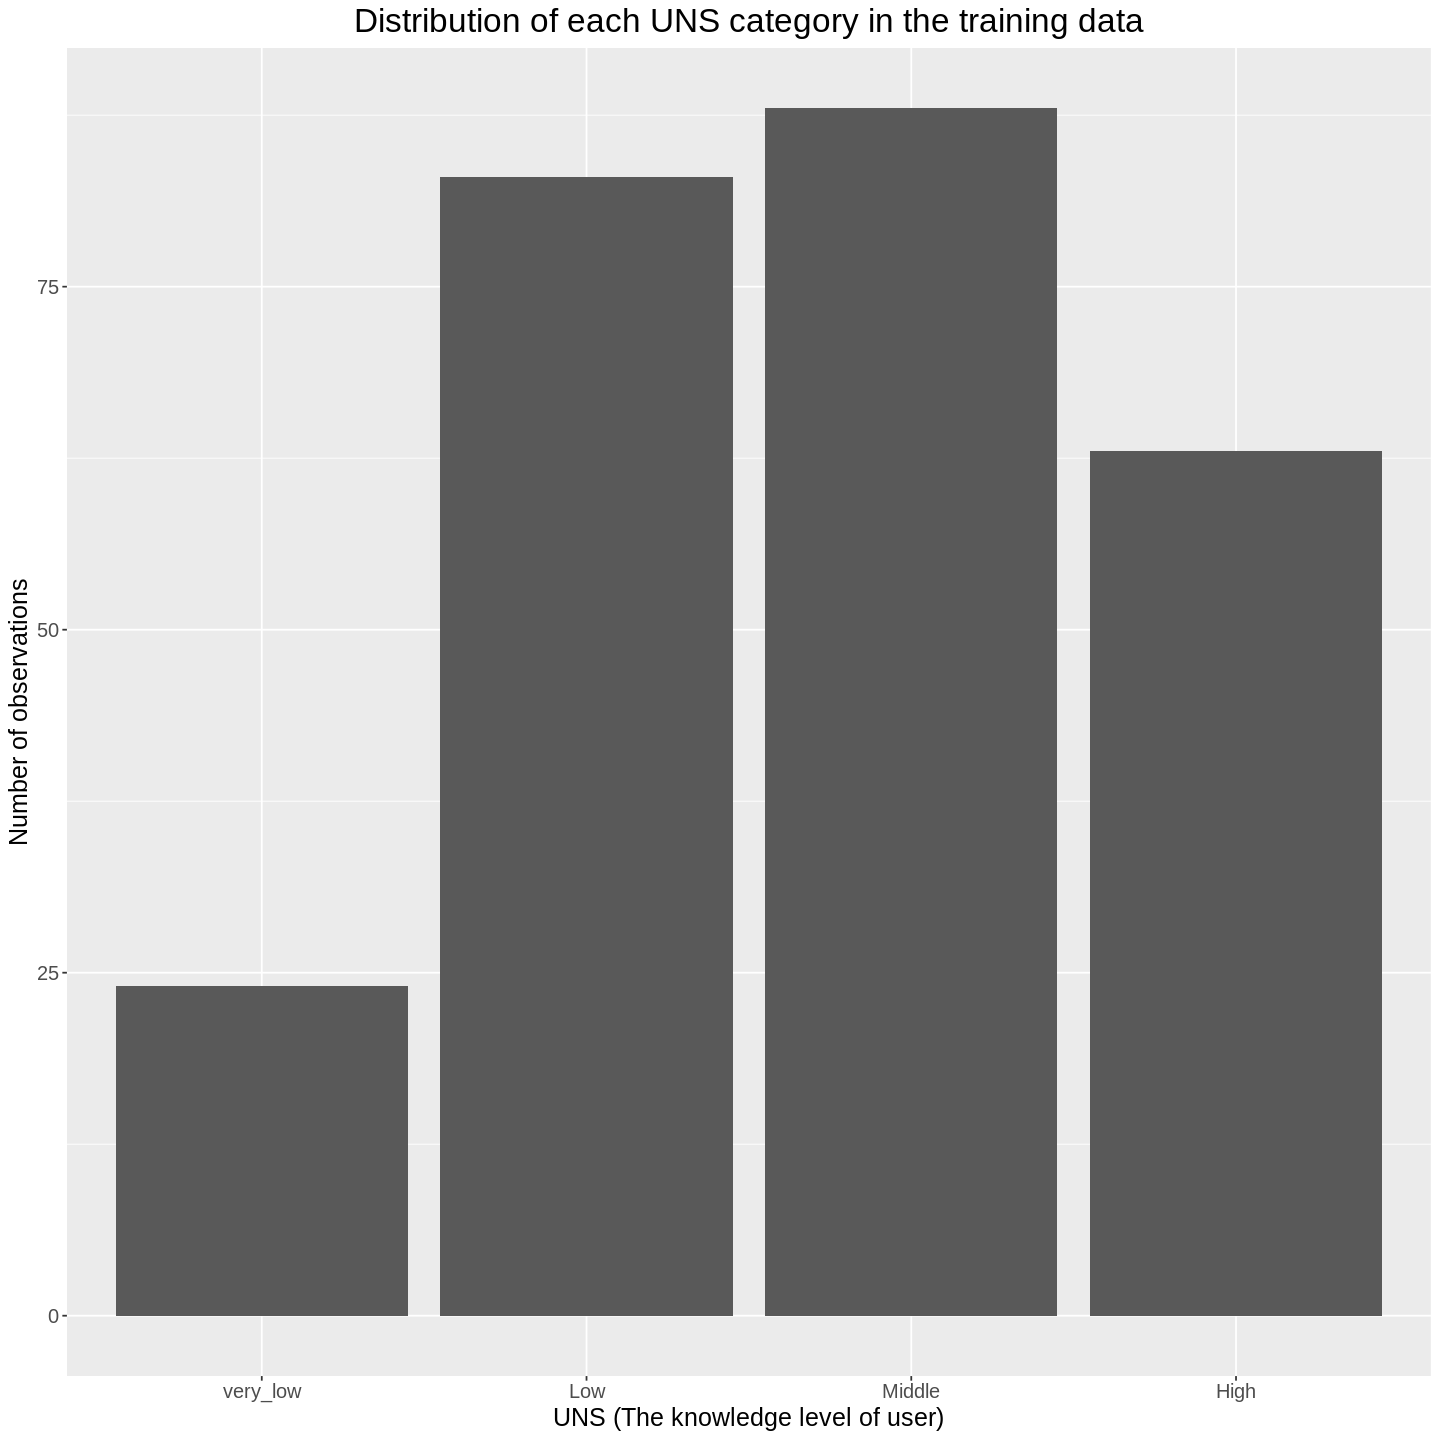

In [51]:
plot <- num_UNS %>%
         ggplot(aes(x = UNS, y = count)) + geom_bar(stat = "identity") + 
         labs(x = "UNS (The knowledge level of user)" , 
              y = "Number of observations") + 
         theme(text = element_text(size = 15))+
         ggtitle("Distribution of each UNS category in the training data") +
         theme(plot.title = element_text(size = 20, hjust = 0.5))
plot

Figure 2: Bar plot showing the distribution of each UNS category in the training data.

<br> </br>

We can see from Figure 2 that there are way more users with a low or middle level of knowledge compared to users with a very low or high level of knowledge. In other words, the distribution of each category is uneven. So, we plan to balance these four categories before doing the predictions using upsampling, in order to make the number of observations the same for each UNS category. This makes it so that each category will have equal influence on the predictions made by the model.

<br>

- <u>Data analysis: </u>

After upsampling the training data so that each UNS category will have the same number of observations, we used cross validation to find the k value which gives us the highest accuracy. We can see from both Figure 3 and the first row of Table 7 that K should be 11, since it gives us the highest accuracy at 85.44%.

In [52]:
# Find the k value that results in the model having the highest accuracy using cross validation
ups_recipe <- recipe(UNS ~ PEG, data = dataset_training) %>% 
              step_upsample(UNS, over_ratio = 1, skip = FALSE) %>%     #create a recipe that upsamples the training data 
                                                                       #so that number of points for each level are the same 
              prep()

upsampled_dataset_training <- bake(ups_recipe, dataset_training)   # apply the recipe onto the training data

upsampled_dataset_training %>%
  group_by(UNS) %>%
  summarize(count = n())     # here we can see the number of data points for each level are the same

UNS,count
<ord>,<int>
very_low,88
Low,88
Middle,88
High,88


Table 6: The result after upsampling the data (all labels having the same number of observations).


<br> </br>
<br> </br>

In [53]:
recipe <- recipe(UNS ~ PEG, data = upsampled_dataset_training) %>%   # selected our target variable to be UNS and predictor variable to be PEG
                step_scale(all_predictors()) %>%  
                step_center(all_predictors()) # scaling and centering the predictor variable so that each variable is worth the same

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%  #tuning the K value
             set_engine("kknn") %>%      #tells R that we're using the K-nearest neighbors algorithm for our model
             set_mode("classification")  #tells R that we're using classification for our model    

vfold <- vfold_cv(upsampled_dataset_training, v = 5, strata = UNS)   # seperate the data into five random groups

gridvals <- tibble(neighbors = seq(from = 1, to = 20))   #creates the list of k values we are going to test

wkflw <- workflow() %>%                              #creates a workflow
             add_recipe(recipe) %>%                  #adds the recipe into the workflow
             add_model(knn_spec)                     #adds the model into the workflow

results <- wkflw  %>%
           tune_grid(resamples = vfold, grid = gridvals)  %>%
           collect_metrics() %>%          
           filter(.metric == "accuracy")%>%    #filters out only the rows with the accuracy metric               
           arrange(desc(mean))                 #arranges the rows in descending order of accuracy
head(results, 5)

kmin <- results %>%           #find the k value with highest accuracy
        slice(1) %>%          #slices the first row of the dataframe to get the row with the highest accuracy 
        pull(neighbors)       #pulls the number of neighbors in the neighbors column

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,multiclass,0.8635621,5,0.007224736,Preprocessor1_Model09
8,accuracy,multiclass,0.8604575,5,0.011424479,Preprocessor1_Model08
1,accuracy,multiclass,0.8578431,5,0.012675253,Preprocessor1_Model01
7,accuracy,multiclass,0.8576797,5,0.010864477,Preprocessor1_Model07
14,accuracy,multiclass,0.8549020,5,0.008816719,Preprocessor1_Model14


Table 7: Results after cross-validating the training data and testing K values on the validation set.
(top 5 K values that gives the model the highest accuracy)


<br> </br>
<br> </br>

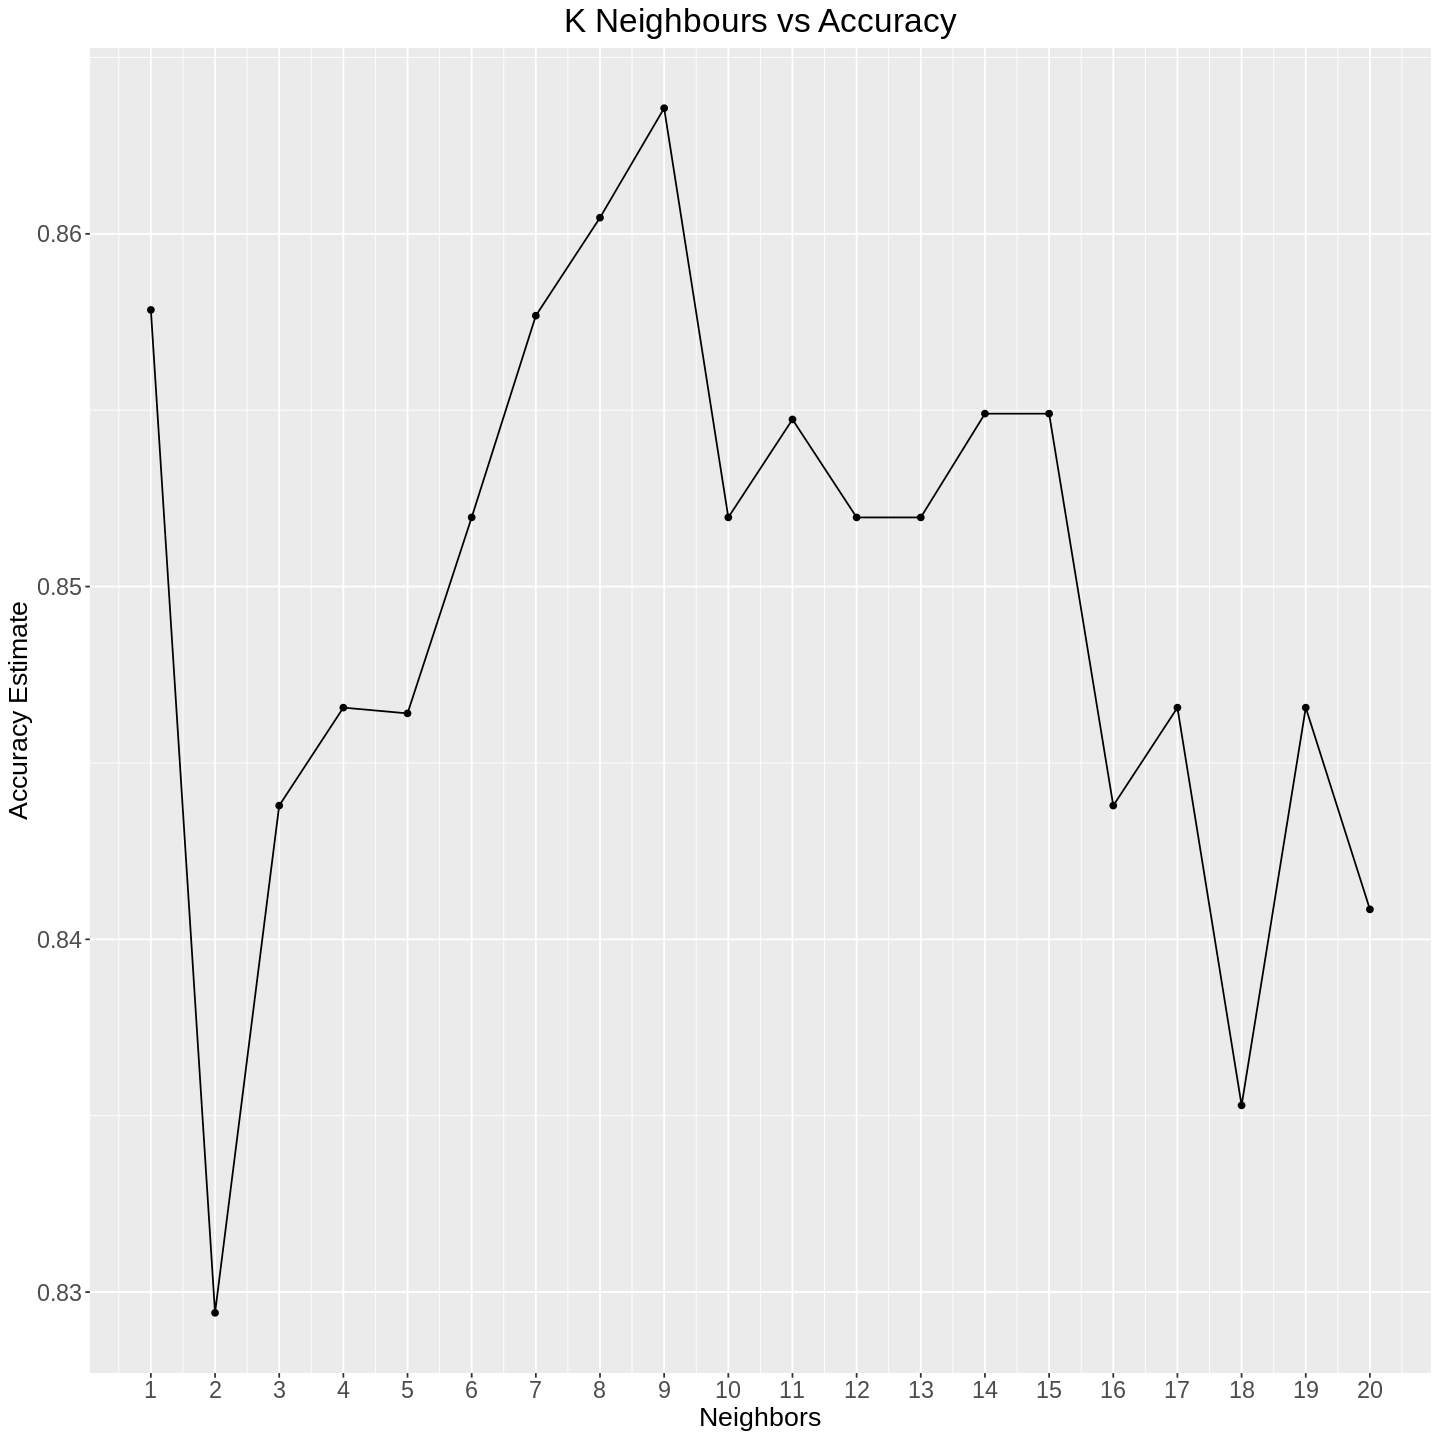

In [54]:
options(repr.plot.width = 12, repr.plot.height = 12)                 #increases plot width and height
accuracy_vs_k <- ggplot(results, aes(x = neighbors, y = mean)) +     #graphs a K vs accuracy scatterplot 
                 geom_point() + geom_line() +                        #specifies that each point in the graph will have a dot and lines that connects
                 labs(x = "Neighbors", y = "Accuracy Estimate") +    #gives the x and y axis titles
                 scale_x_continuous(breaks = seq(0, 20, by = 1)) +   #makes it easier to match each point in the graph with its k value
                 ggtitle("K Neighbours vs Accuracy") +                 #gives the graph a title
                 theme(axis.title.x = element_text(size = 16),       #makes all the labels on the graph bigger
                       axis.text.x = element_text(size = 14),
                       axis.text.y = element_text(size = 14),
                       axis.title.y = element_text(size = 16),
                      plot.title = element_text(size = 20, hjust = 0.5))
    

accuracy_vs_k

Figure 3: A line graph showing the relationship between the number of neighbours chosen and the model's accuracy.


<br> </br>
<br> </br>

Now that we have calculated the most suitable K value for the model to be 11, we plugged it into our model and ran the classifier onto the testing dataset.

In [55]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%      # plug in the best k value that we found above
              set_engine("kknn") %>%      
              set_mode("classification")

knn_fit <- workflow() %>%      
           add_recipe(recipe) %>%             #adds the same recipe above
           add_model(knn_spec_2) %>%          #adds the new model with the best k-value that we found above
           fit(data = upsampled_dataset_training)       #fit the training data

predictions <- knn_fit %>%                   #fits the workflow
               predict(dataset_testing) %>%  #predicts the UNS value  for each observation in the testing data
               bind_cols(dataset_testing)    #puts the column with all the predictions into the testing dataframe

summary <- predictions %>%
            metrics(truth = "UNS", estimate = ".pred_class") %>%  #determines the accuracy (and other metrics) based on each testing set 
                                                                  #observation's predicted UNS value and actual UNS value
           filter(.metric == "accuracy")%>%                       #filters out all the rows with the accuracy metric 
           select(.estimate)                                      #selects the accuracy value
summary

.estimate
<dbl>
0.8758621


Table 8: The accuracy after applying the trained model onto the testing dataset.


<br> </br>
<br> </br>

A confusion matrix is helpful here, as it is able to produce a table that shows the table of predicted UNS categories compared to the actual UNS categories of each test data's observation. We would read it diagonally, from the top left number to the bottom right number, each number representing the number of correct predictions for each UNS category.

To the left and/or right of each row, we can see the number of incorrect predictions the model made, and what category the model incorrectly classified the observation as.

We can see in Figure 4 that the model predicted 23 very_low observations correctly, 42 low observations correctly, 25 middle observations correctly, and 35 high observations correctly.

In [56]:
conf_mat <- predictions %>%          
            conf_mat(truth = UNS, estimate = .pred_class) #creates a confusion matrix
conf_mat

          Truth
Prediction very_low Low Middle High
  very_low       23   0      0    0
  Low             3  45      9    0
  Middle          0   1     24    4
  High            0   0      1   35

Figure 4: Confusion matrix

<br>

- <u>Visualization of the analysis: </u>

In [59]:
predicted <- select(predictions, .pred_class) %>% unlist #unlists each column in the results dataframe so that they can be compared to each other 
                                                         #when determining the number of correct / incorrect predictions
truth <- select(predictions, UNS) %>% unlist
results <- bind_cols(.pred_class = predicted, UNS = truth)  #binds the two unlisted columns to each other again

correct_predictions <- results %>%             #calculates number of correct predictions (when prediction and truth matches each other)
    filter(.pred_class == UNS) %>%
    group_by(UNS) %>%
    summarise(correct_predictions = n()) %>%
    select(-UNS)                              #removes UNS column so that when we bind the three dfs together there won't be duplicate UNS columns

total_predictions <- results %>%              #calculates total number of predictions 
    group_by(UNS) %>%
    summarise(total_predictions = n())

incorrect_predictions <- results %>%          #calculates number of incorrect predictions (when prediction and truth doesn't match each other)
    filter(.pred_class != UNS) %>%
    group_by(UNS) %>%
    summarise(incorrect_predictions = n()) %>%
    select(-UNS)                              #removes UNS column so that when we bind the three dfs together there won't be duplicate UNS columns

prediction_stats <- bind_cols(correct_predictions, incorrect_predictions, total_predictions) %>% #binds all the dataframe columns together
    select(UNS, correct_predictions, incorrect_predictions, total_predictions) #makes all the columns "in order" (for ease of readability)
prediction_stats

UNS,correct_predictions,incorrect_predictions,total_predictions
<fct>,<int>,<int>,<int>
very_low,23,3,26
Low,45,1,46
Middle,24,10,34
High,35,4,39


Table 9: A tibble showing the number of correct, incorrect and total predictions made for each UNS category.


<br> </br>
<br> </br>

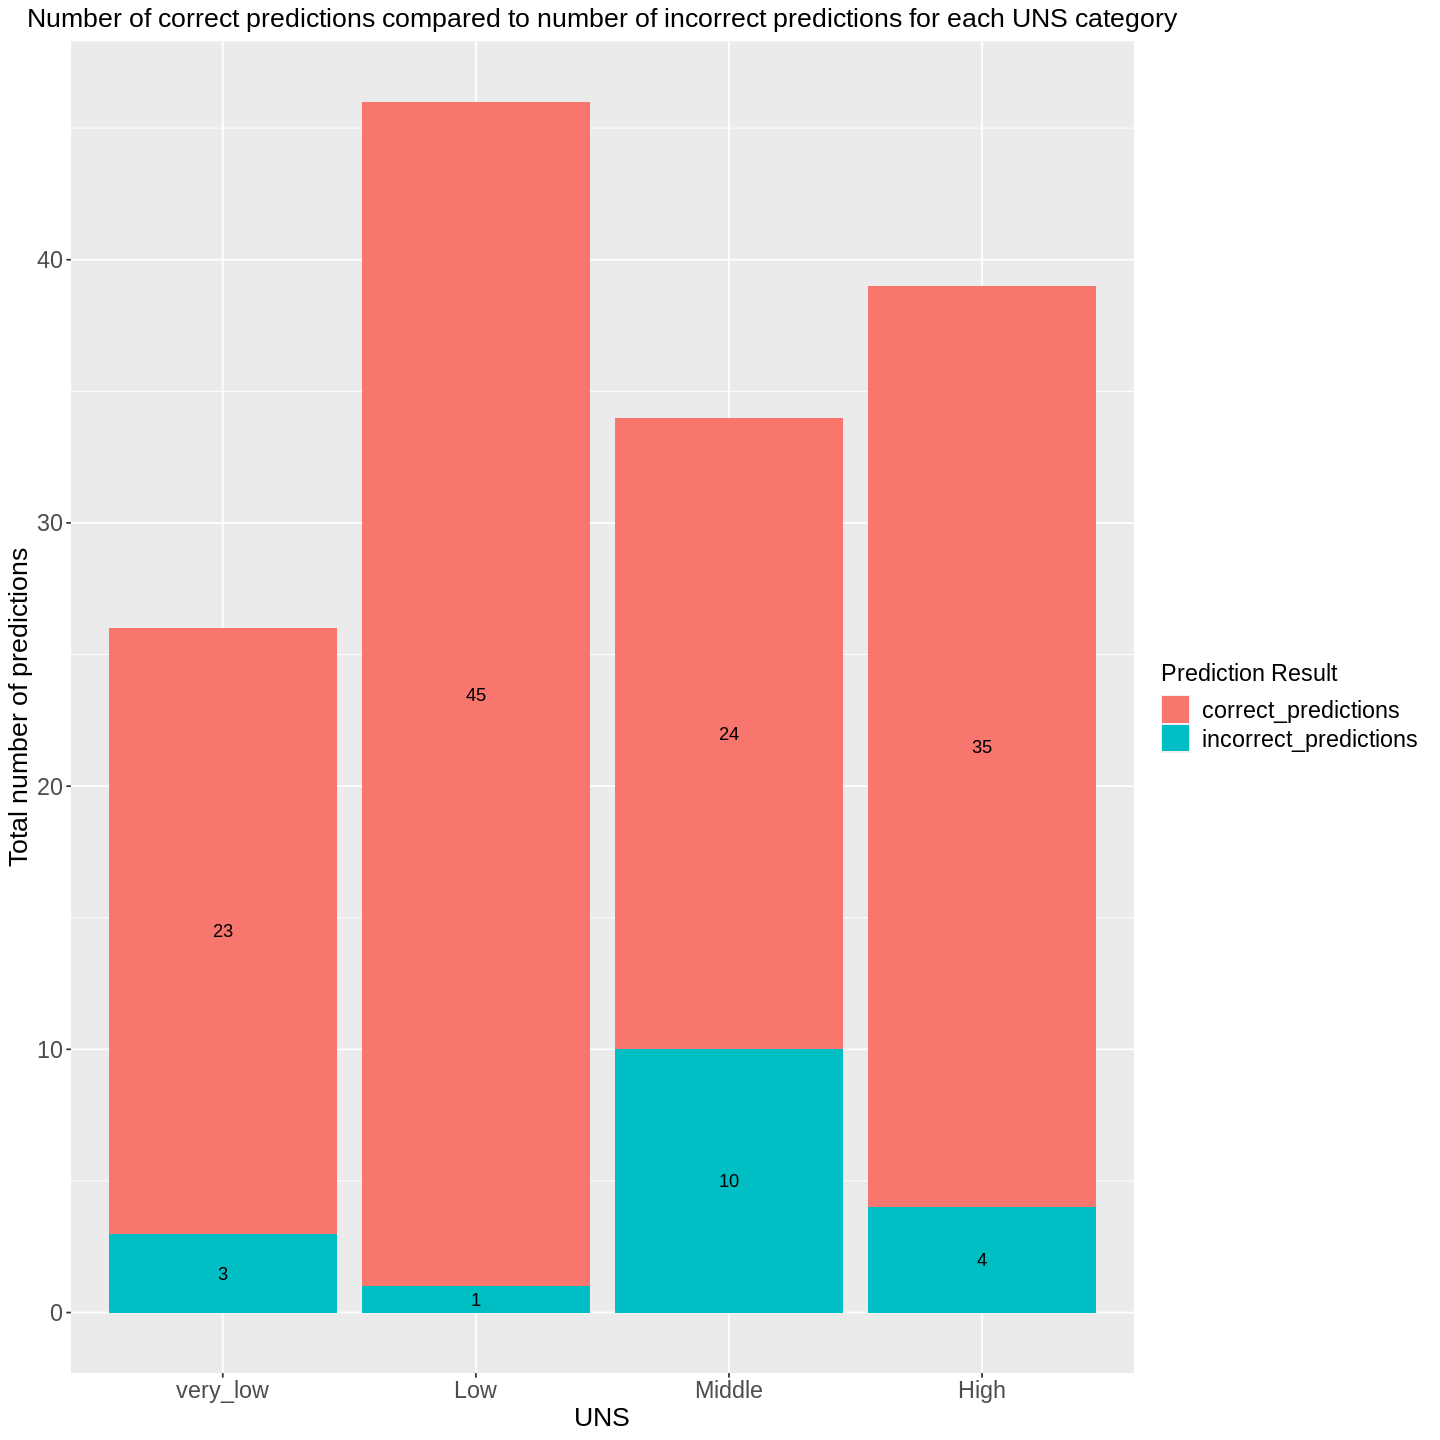

In [60]:
prediction_stats1 <- prediction_stats %>% 
  select(-total_predictions) %>%
  gather(key = predict_result, value = total_predictions, correct_predictions, incorrect_predictions) 
#so that fill portion of bargraph can distinguish between correct and incorrect 

options(repr.plot.width = 12, repr.plot.height = 12) # increases size of graph for ease of readability

results_graph <- ggplot(prediction_stats1, aes(x = UNS, y = total_predictions, fill = predict_result)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(y = "Total number of predictions", fill = "Prediction Result") +
    geom_text(aes(label = total_predictions), position = position_stack(vjust = 0.5)) +
    theme(                                                                             #increases the size of the plot titles and labels
        axis.title.x = element_text(size = 16),
        axis.text.x = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        axis.text.y = element_text(size = 14), 
        axis.title.y = element_text(size = 16),
        plot.title = element_text(size = 16, hjust = 0.5)) +
        ggtitle("Number of correct predictions compared to number of incorrect predictions for each UNS category") #gives the plot a suitable title
                            
results_graph    

Figure 4: A stacked bar plot showing the number of correct vs incorrect predictions for each UNS category.


<br> </br>
<br> </br>

<b> Discussion: </b>

We found that the K-nearest neighbours classifier developed in the Methods and Results section had an accuracy of 86.21% (from Table 8). This means that roughly 43/50 classifiers' predictions for the correct knowledge level based on PEG will be correct, or roughly 7/50 predictions will be incorrect. However, just looking at this percentage is not an optimal method to gauge if our classifier is an acceptable one as there are other factors which may influence this value. For example, we need to consider our relatively small sample size, in which each occurrence would have more weight as opposed to a larger sample size that is more capable of drowning out noise. Also, the effectiveness of the classifier is crucially dependent on which context it is applied and what the classifier is classifying must be taken into consideration. For example, an ~86% accuracy in an ad-blocker is efficient; the 14% that do get through may offer slight annoyance, but they are just advertisements and nothing of serious consequence. However, one could imagine the destruction of a sub-100% accuracy classifier for matters of serious consequence, such as for a classifier that recognizes human pedestrians from other objects in a self-driving system. Furthermore, if that system was put into wide use, the 16% would amount to innumerable pedestrians being unrecognized by self-driving cars and ultimately causing catastrophe. Based on relevance, our developed classifier performs adequately for the categories it is meant to classify.


From our analysis, we found that there is a high correlation between a student’s exam score and their level of knowledge. The high correlation (0.911) between exam scores and level of knowledge in the dataset reflects the current education system with standardized testing. We found that the most common variables were “Middle” and “High”, suggesting that most users perform relatively well on their exams and are classified as having a middle or high level of knowledge of the material. For future applications, our findings suggest that students can predict or grasp how much they know of the material based on their exam scores, and students and instructors may use our classifier to roughly estimate a student’s level of knowledge in a course. We also saw that there is a weak correlation between the amount of time a student spends studying and their exam score (0.206), and/or their level of knowledge (0.207). In turn, this suggests that there are factors other than a student’s study time that impacts their exam scores. From research, we learned that factors such as overall intelligence, ability to focus, reaction under stress, and personal events can all affect a student’s exam performance (MACHUCHO, 2018). As such, physiological challenges can cause impairments and may influence a student’s lack of success in academic achievements. Furthermore, a student’s level of prerequisite knowledge may also influence the outcome of their cumulative test scores. As students who already have an adept grasp on certain concepts would spend less time preparing, than their other peers who may have never seen the same concepts before. For example, an individual who took Calculus in high school with the BC curriculum versus an individual who took higher-level mathematics with the IB curriculum would have different backgrounds in the same subject, with the latter being much more prepared to face challenging content because they already have experience. Therefore, even if both individuals put in similar amounts of effort, the latter would hypothetically still receive the better result. As an extraneous variable, somehow controlling this variable and others would help to increase the ecological validity of our findings. Relating back to the aforementioned standardized testing, it makes us wonder basing a student’s abilities in a specific area solely on their exam scores is truly the best way to classify a student’s level of knowledge.


It is important to iterate that correlation does not equal causation. No matter the strength of the relationship between PEG and UNS, high exam scores is definitely not the only variable that contributes to knowledge level. In future applications, we could deduce a student’s knowledge level (UNS) based on their exam scores (PEG) with the assumption that exam scores would classify their knowledge. As such, these data-driven findings serve as a foundation for future studies to deduce the contributing variables to high academic standing. Perhaps we could also study possible relationships between the professor’s education standing and the knowledge level of their students, or possible factors that influence the professor’s knowledge level. These questions both pose relevance because the proficiency of the professors may also influence the student’s knowledge level. However small our findings, we hope they may contribute to the much larger picture of deducing an individual’s knowledge level regarding a certain subject.

<br> </br>
<b> References: </b>

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

H. T. Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.

Machucho, M. (2018, May 13). Factors that affect students' test scores. Owlcation. Retrieved December 7, 2021, from https://owlcation.com/academia/Factors-That-Affect-Students-Test-Scores. 